# Project: Wrangling and Analyze Data

## 1. Import Packages That Will Be Used for Data Wrangling and Analysis

In [1]:
# For analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# For programmatically downloading tweet image predictions
import requests
import io

# For querying Twitter API for each tweet's JSON data
import tweepy

# For saving and reading twitter data in JSON .txt file
import json

# To use regular expression
import re

# Upgrade seaborn to be able to use relplot() and catplot()
# !pip install seaborn --upgrade

## 2. Data Gathering
There are three pieces of data I must gather for this project:

1. WeRateDogs Twitter archive data,
2. Image Prediction data, and
3. Additional data via Twitter API

#### 2.1 Read in WeRateDogs Twitter archive data using pd.read_csv()

In [2]:
# Read in twitter_archive_enhanced.csv
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

# Examine the archive dataframe
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### 2.2 Download the tweet image predictions using the Requests library

In [3]:
# Store the url in a variable named image_prediction_url
image_prediction_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Confirm get request was successful
response = requests.get(image_prediction_url)
response

<Response [200]>

In [87]:
# Download image-predictions.tsv programmatically 
with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [4]:
# Read image-predictions into a DataFrame 
img_prediction_df = pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep='\t')

img_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 2.3 Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

First, I'll need the API keys from my Twitter developer account. So as not to display those here, I'll put them in a config file and use configparser to parse in the codes.

In [5]:
# Import Twitter API access tokens stored in a config.ini file
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [6]:
# Assign keys in config file to variables
consumer_key = config['twitter']['api_key']
consumer_secret = config['twitter']['api_secret']
access_token = config['twitter']['access_token']
access_secret = config['twitter']['access_secret']

In [7]:
# Pass the API keys to tweepy's OAuthHandler and authenticate
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

Authentication done. Time to import additional data using each tweet id.

In [8]:
# First, how many tweets are in archive_df?

# Assign rows in the tweet_id column of archive_df to tweet_ids
tweet_ids = archive_df.tweet_id.values

# How many tweet ids are there?
len(tweet_ids)

2356

Making 2356 GET status API requests at once will raise an error of 'Rate Limit Exceeded'. Since I am only able to query 900 tweets, I'll need to ...

In [9]:
# Initialise an empty dictionary to catch errors
error_dict = {}

# Let's keep track of what's done
count = 0

# Save each tweet's json data as a new line in a .txt file
with open('tweet_json.txt', 'w') as file:

    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        
        try:
            # Getting the status id of each tweet id
            tweet = api.get_status(tweet_id, 
                                   tweet_mode='extended',
                                   wait_on_rate_limit_notify=True,   # Notify when rate limit is reached
                                   wait_on_rate_limit=True)         # Wait for rate limit to replenish
            print("Success")
            # Convert each tweet status to a JSON object and save to file
            json.dump(tweet._json, file)
            file.write('\n')
        
        # To catch errors that occur 
        except tweepy.TweepError as error:
            # Append the errors to error_dict
            error_dict[tweet_id] = error
            # print
            print("Error")

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Error
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 886054160059072

Error
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
29

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Error
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
80

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
1560: 688547210804498433
Success
15

Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Rate limit reached. Sleeping for: 744
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Succe

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
23

In [10]:
# Examine the errors I caught
print(f'{len(error_dict)} error messages:')

print(error_dict)

29 error messages:
{888202515573088257: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 873697596434513921: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 872668790621863937: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 872261713294495745: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 869988702071779329: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 866816280283807744: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 861769973181624320: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 856602993587888130: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 856330835276025856: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 851953902622658560: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 851861385021730816: TweepError([{'code':

29 tweet IDs were not found in @Dog_rates database.

In [12]:
# Initialise an empty list
list_for_tweets = []

# Read tweet_json text file, extract required data, and append to the empty list
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file.readlines():
        tweet_line = json.loads(line)
        
        # Extract the required data
        tweet_id = tweet_line['id']
        retweet_count = tweet_line['retweet_count']
        favorite_count = tweet_line['favorite_count']
        
        # Append extracted data to the empty list
        list_for_tweets.append({
                "tweet_id" : tweet_id,
                "retweet_count" : retweet_count,
                "favorite_count" : favorite_count})

In [13]:
# Convert our list of dictionaries to a pandas dataframe
tweets_df = pd.DataFrame(list_for_tweets, columns=["tweet_id", 'retweet_count', 'favorite_count'])

In [14]:
# Examine the tweets_df
tweets_df.sample(5)

,tweet_id,retweet_count,favorite_count
332,831670449226514432,1685,9767
1459,693095443459342336,403,1698
1428,695314793360662529,1295,3329
288,836380477523124226,2745,13879
1844,675145476954566656,779,1911


So, I've gathered all three required datasets:
- `twitter_archive_enhanced.csv` as `archive_df`
- `image_prediction.tsv` as `img_prediction_df`
- `tweet_json.txt` as `tweets_df`

## 3. Assessing Data
In this section, I'll assess (visually and programmatically) each of the three dataframes in order to detect and document **eight (8) quality issues and two (2) tidiness issue**.

#### 3.1 Assessing archive_df (Twitter archive data)

###### Visual assessment of archive_df

In [15]:
# Visualise the entire dataframe
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


Quality issues:
- In the `name` column, there are invalid names like "quite", "a", "an", "the", etc. I wonder if all invalid names are in lower case.
- Invalid denominator: In the `rating_denominator` column, I spotted a tweet with a rating denominator of 2.

NB: While there are ratings with numerator above 10, this is part of the unique rating system of @dog_rates, hence not a problem.

Tidiness issue: 
- There are four columns (doggo, floofer, puppo, pupper) stating the dog stage. They should be collapsed into one column, "dog_stage".

###### Programmatic assessment of archive_df

In [16]:
# Check the first five rows
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [17]:
# Check five random rows
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1249,711306686208872448,NaN,NaN,2016-03-19 21:41:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What hooligan sent in pictures w/out a dog in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711306686...,3,10,None,None,None,None,None
1893,674752233200820224,NaN,NaN,2015-12-10 00:47:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Everyone please just appreciate how perfect th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674752233...,12,10,None,None,None,None,None
144,863907417377173506,NaN,NaN,2017-05-15 00:02:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Albus. He's quite impressive at hide a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863907417...,13,10,Albus,None,None,None,None
1986,672884426393653248,NaN,NaN,2015-12-04 21:05:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Marvelous dog here. Rad ears. Not very soft. L...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672884426...,6,10,None,None,None,None,None
961,751132876104687617,NaN,NaN,2016-07-07 19:16:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,None,None,None,puppo


In [18]:
# Examine the source column
archive_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

Quality issue:
- `source` column contains url and plain text. 

In [19]:
# Examine the first row of the text column
archive_df.loc[0, 'text']

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [20]:
# Get an overview of archive_df
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Quality issue: 
- `timestamp` and `retweeted_status_timestamp` should be timestamp datatype, not string.

- With 181 `retweeted_status_id` rows, it is evident the same dog could be recorded twice of more due to retweets or replies.

In [21]:
# Examine the 78 non-null rows in "in_reply_to_status_id"

archive_df[archive_df['in_reply_to_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


These seem to contain upgrades or demotions of original ratings (e.g. view text of rows 1497, 1844). 

Ideally, I should take the upgraded rating and drop the original, but the IDs of the original ratings are in an unusable format (e.g. 8.862664e+17). Hence, to avoid repetition, I'll also drop all rows where `in_reply_to_status_id` is not null.

In [22]:
# Generate descriptive statistics of archive_df
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [23]:
# Check for duplicated tweet ids
archive_df['tweet_id'].duplicated().sum()

0

In [24]:
# Examine the name column to further understand the issue spotted during visual assessment
archive_df['name'].value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
the            8
Sadie          8
Buddy          7
an             7
Daisy          7
Bailey         7
Toby           7
Scout          6
Leo            6
Bella          6
Milo           6
Dave           6
Stanley        6
Koda           6
Jax            6
Oscar          6
Rusty          6
Jack           6
Larry          5
            ... 
Frönq          1
Timofy         1
Dixie          1
Harlso         1
River          1
Philippe       1
Tedrick        1
Dylan          1
Lorelei        1
Erik           1
Aiden          1
Noosh          1
Horace         1
Pubert         1
Pancake        1
Fiji           1
Jarvis         1
Cuddles        1
life           1
Bobbay         1
Kevon          1
Ralph          1
Willem         1
Blu            1
Bonaparte      1
Ace            1
Andy           1
Kayla         

In [25]:
# Are all invalid names in lowercase?

# Use regex to isolate lowercase names
lowercase_names = archive_df['name'].str.contains('^[a-z]', regex = True)

# Examine all lowercase names
archive_df[lowercase_names]['name'].value_counts()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
getting          2
not              2
mad              2
actually         2
by               1
officially       1
infuriating      1
space            1
life             1
my               1
incredibly       1
unacceptable     1
such             1
this             1
his              1
old              1
light            1
all              1
Name: name, dtype: int64

It seems all lowercase names are invalid names.

In [26]:
# Examine the rating_denominator column to further understand the issue spotted during visual assessment

# Print a message to state how many rows have ratings with invalid denominator
print(f"{len(archive_df.query('rating_denominator != 10'))} dog ratings have invalid denominators. View them below: ")
  
# Display the rows that have ratings with invalid denominator
archive_df.query('rating_denominator != 10')

23 dog ratings have invalid denominators. View them below: 


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


#### 3.2 Assessing img_prediction_df (Image Prediction data)

###### Visual assessment of img_prediction_df

In [27]:
# Visualise the entire dataframe
img_prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


Quality: 
- In `p1`, `p2`, `p3`, some dog breeds are in lowercase, others have the first letter capitalised.
- `img_num` column is not needed.

###### Programmatic assessment of img_prediction_df

In [28]:
# View first five rows of img_prediction dataframe
img_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [29]:
# View five random rows of img_prediction_df
img_prediction_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
171,668994913074286592,https://pbs.twimg.com/media/CUi_UtnWIAEtfqz.jpg,1,hog,0.113789,False,English_springer,0.089763,True,French_bulldog,0.082186,True
1401,768855141948723200,https://pbs.twimg.com/media/CquFrCKWAAAr32m.jpg,1,chow,0.720219,True,Brabancon_griffon,0.058365,True,Rottweiler,0.055114,True
854,696488710901260288,https://pbs.twimg.com/media/CapsyfkWcAQ41uC.jpg,1,briard,0.369063,True,Scotch_terrier,0.168204,True,giant_schnauzer,0.120553,True
938,703631701117943808,https://pbs.twimg.com/media/CcPNS4yW8AAd-Et.jpg,2,window_shade,0.909533,False,window_screen,0.011427,False,brass,0.008882,False
1571,794983741416415232,https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg,3,schipperke,0.363272,True,kelpie,0.197021,True,Norwegian_elkhound,0.151024,True


In [30]:
# Get an overview of img_prediction_df
img_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
# Generate descriptive statistics of img_prediction_df
img_prediction_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [32]:
# Check for duplicated tweets
img_prediction_df['tweet_id'].duplicated().sum()

0

In [33]:
# Check for duplicated dog picture
img_prediction_df['jpg_url'].duplicated().sum()

66

Quality issue: 
- There are 66 duplicate pictures.

In [34]:
# Check for missing or null values in img_prediction_df
img_prediction_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

#### 3.3 Assessing tweets_df ()

###### Visual assessment of tweets_df

In [35]:
# Examine the entire tweets_df dataframe
tweets_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33696
1,892177421306343426,5272,29222
2,891815181378084864,3464,21977
3,891689557279858688,7183,36754
4,891327558926688256,7717,35183
5,891087950875897856,2586,17749
6,890971913173991426,1647,10330
7,890729181411237888,15679,56664
8,890609185150312448,3604,24425
9,890240255349198849,6068,27849


###### Programmatic assessment of tweets_df

In [36]:
# Examine the first five rows of tweets_df
tweets_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33696
1,892177421306343426,5272,29222
2,891815181378084864,3464,21977
3,891689557279858688,7183,36754
4,891327558926688256,7717,35183


In [37]:
# Examine five random rows of tweets_df
tweets_df.sample(5)

,tweet_id,retweet_count,favorite_count
564,800141422401830912,2383,14469
661,788765914992902144,9625,25825
2313,666082916733198337,37,92
965,748575535303884801,1799,5613
2125,669625907762618368,1560,3108


In [38]:
# Get an overview of tweets_df
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
tweet_id          2327 non-null int64
retweet_count     2327 non-null int64
favorite_count    2327 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


In [39]:
# Generate descriptive statistics of tweets_df
tweets_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2458.701762,7026.698754
std,6.820795e+16,4163.790815,10919.821504
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.500000,1220.500000
50%,7.178418e+17,1144.000000,3038.000000
75%,7.986547e+17,2845.000000,8564.000000
max,8.924206e+17,70334.000000,144248.000000


In [40]:
# Check tweets_df for duplicated tweet IDs
tweets_df['tweet_id'].duplicated().sum()

0

In [41]:
# Check tweets_df for missing or null values
tweets_df.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

### Quality issues
`archive_df` table:
1. There are invalid dog names in the `name` column, all of which incidentally are lowercase.

2. Some ratings have invalid denominator in `rating_denominator` column

3. `source` column contains href (url and plain text). Extract the string.

4. `text` column contains ratings data already present in the ratings columns.

5. `retweeted_status_id` column contains non-null rows, indicating that those rows are retweets. The rows need to be dropped because we don't want to have the same dog recording more than once (according to the project requirements).

6. `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_user_id` contain unwanted data. The columns will be dropped.

7. Incorrect datatype of `timestamp` and `retweeted_status_timestamp` columns. I will convert to datetime.

8. The dog stages are `object` types, but they should be `category` types since the possible values are limited.

9. `tweet_id` should be converted from int to string after merging all tables. 

`img_prediction_df` table:
10. Irrelevant `img_num` column will be dropped.

11. `jpg_url` column has duplicate values that need to be dropped.


### Tidiness issues
1. The three tables (`archive_df`, `img_prediction_df`, `tweets_df`) should be merged into one.

2. The four dog stage columns (`doggo`, `floofer`, `pupper`, `puppo`) in Twitter Archive (`archive_df`) should be one column.

## 4. Cleaning Data
In this section, I'll clean **all** of the issues I documented while assessing. 

**Before cleaning, let's make copies of original data.**

In [42]:
# Make copies of original pieces of data
df_archive_clean = archive_df.copy()
df_img_clean = img_prediction_df.copy()
df_tweets_clean = tweets_df.copy()

**Now, we can address the issues**

### Issue #1:

#### Define: 
- Remove invalid or nonstandard names in the `name` column.

#### Code

In [43]:
# Use regex to isolate lowercase names
lower_names = df_archive_clean['name'].str.contains('^[a-z]', regex = True)

In [44]:
# Filter out lowercase names
df_archive_clean = df_archive_clean[df_archive_clean['name'].str.contains('^[A-Z]+')]

#### Test

In [45]:
# Confirm lowercase names (thus invalid and nonstandard names) have been removed
df_archive_clean[lower_names]['name'].value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Series([], Name: name, dtype: int64)

### Issue #2:

#### Define:
- Drop rows with invalid denominators (i.e. where denominator is not 10)

#### Code

In [46]:
# Filter out rows where rating_denominator is not equal to 10
df_archive_clean = df_archive_clean.query('rating_denominator == 10')

#### Test

In [47]:
# How many rows contain rating_denominator not equal to 10
len(df_archive_clean.query('rating_denominator != 10'))

0

### Issue #3:

#### Define: 
- Extract text from `source` column.

#### Code

In [48]:
# Import BeautifulSoup for extracting the text
from bs4 import BeautifulSoup

In [49]:
# Apply BeautifulSoup xml parser to each row of source column
soup = df_archive_clean['source'].apply(lambda x: BeautifulSoup(x, 'xml'))

In [50]:
# Initialise list to store the new text values
source_text = []

# Loop through each row and extract text
for item in soup:
    x = item.get_text()
    source_text.append(x)

In [51]:
# Update source column with source_text
df_archive_clean['source'] = source_text

#### Test

In [52]:
# Confirm source column has been updated from href to plain text
df_archive_clean['source'].value_counts()

Twitter for iPhone     2101
Vine - Make a Scene      87
Twitter Web Client       29
TweetDeck                10
Name: source, dtype: int64

### Issue #4:

#### Define: 
- Drop `text` column. Info it contains data found in other columns

#### Code

In [53]:
# Drop "text" column
df_archive_clean.drop('text', axis=1, inplace=True)

#### Test

In [54]:
# Confirm "text" column was dropped
df_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #5:

#### Define: 
To avoid multiples ratings of the same dog, drop rows where:
- `retweeted_status_id` is not null.
- `in_reply_to_status_id` is not null.

#### Code

In [55]:
# Select only rows where retweeted_status_id is null
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_id'].isnull()]

# Select only rows where in_reply_to_status_id is null
df_archive_clean = df_archive_clean[df_archive_clean['in_reply_to_status_id'].isnull()]

#### Test

In [56]:
# Confirm that (in_reply_to_status_id, retweeted_status_id) are null
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      1979 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1979 non-null object
source                        1979 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1976 non-null object
rating_numerator              1979 non-null int64
rating_denominator            1979 non-null int64
name                          1979 non-null object
doggo                         1979 non-null object
floofer                       1979 non-null object
pupper                        1979 non-null object
puppo                         1979 non-null object
dtypes: float64(4), int64(3), object(9)
memory usage: 262.8+ KB


### Issue #6:

#### Define: 
- Drop 6 irrelevant columns (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`)

#### Code

In [57]:
# Drop the 6 irrelevant columns
df_archive_clean.drop(columns= ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)

#### Test

In [58]:
# Confirm that irrelevant columns were dropped
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              1979 non-null int64
timestamp             1979 non-null object
source                1979 non-null object
rating_numerator      1979 non-null int64
rating_denominator    1979 non-null int64
name                  1979 non-null object
doggo                 1979 non-null object
floofer               1979 non-null object
pupper                1979 non-null object
puppo                 1979 non-null object
dtypes: int64(3), object(7)
memory usage: 170.1+ KB


### Issue #7:

#### Define: 
Merge the dog stage columns (doggo, floofer, pupper, puppo) into one column, `dog_stage`, and drop the unwanted columns.

#### Code

In [59]:
# First, replace all "None" values in each dog_stage column with ""
df_archive_clean['doggo'].replace("None",  "", inplace=True)
df_archive_clean['floofer'].replace("None", "", inplace=True)
df_archive_clean['pupper'].replace("None", "", inplace=True)
df_archive_clean['puppo'].replace("None", "", inplace=True)

In [60]:
# Next, add the columns together
df_archive_clean["dog_stage"] = df_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].agg(''.join, axis=1)

In [61]:
# Examine the values in the new "dog_stage" column
df_archive_clean['dog_stage'].value_counts()

                1657
pupper           210
doggo             70
puppo             23
floofer            9
doggopupper        8
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

11 rows have multiple dog stages e.g. doggopupper, doggofloofer. Let's hyphenate the multi-stage rows.

In [62]:
# Separate multi-stage rows with '-'
df_archive_clean['dog_stage'].mask(df_archive_clean['dog_stage'] == 'doggopupper', 'doggo-pupper', inplace=True)
df_archive_clean['dog_stage'].mask(df_archive_clean['dog_stage'] == 'doggofloofer', 'doggo-floofer ', inplace=True) 
df_archive_clean['dog_stage'].mask(df_archive_clean['dog_stage'] == 'doggopuppo', 'doggo-puppo', inplace=True)

In [63]:
# Replace empty rows with "None"
df_archive_clean['dog_stage'] = df_archive_clean['dog_stage'].replace('', 'None')

In [64]:
# Drop the four columns that were merged into 'dog_stage'
df_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [65]:
# Examine new dog_stage column
df_archive_clean['dog_stage'].value_counts()

None              1657
pupper             210
doggo               70
puppo               23
floofer              9
doggo-pupper         8
doggo-floofer        1
doggo-puppo          1
Name: dog_stage, dtype: int64

In [66]:
# Confirm the four columns were successfully dropped
df_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

### Issue #8:

#### Define: 
- Drop `img_num` column from df_img_clean table

#### Code

In [67]:
# Drop the img_num column from the df_img_clean table
df_img_clean.drop('img_num', axis=1, inplace=True)

#### Test

In [68]:
# Confirm img_num column was successfully dropped 
df_img_clean.columns

Index(['tweet_id', 'jpg_url', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### Issue  #9:

#### Define:
- Drop duplicate `jpg_url` rows in `df_img_clean`

#### Code

In [69]:
# Check for duplicated dog picture
df_img_clean['jpg_url'].duplicated().sum()

66

In [70]:
# Remove duplicated dog pictures using jpg_url subset
df_img_clean.drop_duplicates(subset='jpg_url', inplace=True)

#### Test

In [71]:
# Confirm duplicated dog pictures have been removed
df_img_clean['jpg_url'].duplicated().sum()

0

### Issue  #10:

#### Define: 
- Merge the three tables (df_archive_clean, df_img_clean, and df_tweets_clean) on tweet_id

#### Code

In [72]:
# Inner merge df_archive clean with df_img_clean
archive_img_mrg = df_archive_clean.merge(df_img_clean, on='tweet_id')

# Inner merge archive_img_mrg with df_tweets_clean
df_merged_clean = archive_img_mrg.merge(df_tweets_clean, on='tweet_id')

#### Test

In [73]:
# Examine the merged table
df_merged_clean

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,dog_stage,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,13,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,6969,33696
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,13,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5272,29222
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,12,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3464,21977
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,13,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7183,36754
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,12,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,7717,35183
5,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,13,10,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,2586,17749
6,890971913173991426,2017-07-28 16:27:12 +0000,Twitter for iPhone,13,10,Jax,None,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,1647,10330
7,890729181411237888,2017-07-28 00:22:40 +0000,Twitter for iPhone,13,10,None,None,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,15679,56664
8,890609185150312448,2017-07-27 16:25:51 +0000,Twitter for iPhone,13,10,Zoey,None,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,3604,24425
9,890240255349198849,2017-07-26 15:59:51 +0000,Twitter for iPhone,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,6068,27849


In [74]:
# An overview of the merged table
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851 entries, 0 to 1850
Data columns (total 19 columns):
tweet_id              1851 non-null int64
timestamp             1851 non-null object
source                1851 non-null object
rating_numerator      1851 non-null int64
rating_denominator    1851 non-null int64
name                  1851 non-null object
dog_stage             1851 non-null object
jpg_url               1851 non-null object
p1                    1851 non-null object
p1_conf               1851 non-null float64
p1_dog                1851 non-null bool
p2                    1851 non-null object
p2_conf               1851 non-null float64
p2_dog                1851 non-null bool
p3                    1851 non-null object
p3_conf               1851 non-null float64
p3_dog                1851 non-null bool
retweet_count         1851 non-null int64
favorite_count        1851 non-null int64
dtypes: bool(3), float64(3), int64(5), object(8)
memory usage: 251.3+ KB


### Issue #11:

#### Define: 
Datatype conversions:
- Convert `timestamp` column from object type to datetime.
- Convert `dog_stage` from object type to category.

#### Code

In [75]:
# Convert timestamp column from obect to datetime type
df_merged_clean['timestamp'] = pd.to_datetime(df_merged_clean['timestamp'])

# Convert dog_stage column from object to category type
df_merged_clean['dog_stage'] = df_merged_clean['dog_stage'].astype('category')

#### Test

In [76]:
# Overview of df_merged_clean
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851 entries, 0 to 1850
Data columns (total 19 columns):
tweet_id              1851 non-null int64
timestamp             1851 non-null datetime64[ns]
source                1851 non-null object
rating_numerator      1851 non-null int64
rating_denominator    1851 non-null int64
name                  1851 non-null object
dog_stage             1851 non-null category
jpg_url               1851 non-null object
p1                    1851 non-null object
p1_conf               1851 non-null float64
p1_dog                1851 non-null bool
p2                    1851 non-null object
p2_conf               1851 non-null float64
p2_dog                1851 non-null bool
p3                    1851 non-null object
p3_conf               1851 non-null float64
p3_dog                1851 non-null bool
retweet_count         1851 non-null int64
favorite_count        1851 non-null int64
dtypes: bool(3), category(1), datetime64[ns](1), float64(3), int64(5), obj

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [77]:
# Save merged file to csv file named 'twitter_archive_master.csv'
df_merged_clean.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

## Analyzing and Visualizing Data
In this section, I'll analyse and visualise the wrangled data to produce **three (3) insights and one (1) visualization.**

In [78]:
# Read in the twitter_archive_master csv
df_twitter_archive = pd.read_csv('twitter_archive_master.csv')

# Display the first five rows
df_twitter_archive.head()

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,dog_stage,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,13,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,6969,33696
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,13,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5272,29222
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,12,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3464,21977
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,13,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7183,36754
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,12,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,7717,35183


### Q1: Is there a correlation between favourites and retweets?

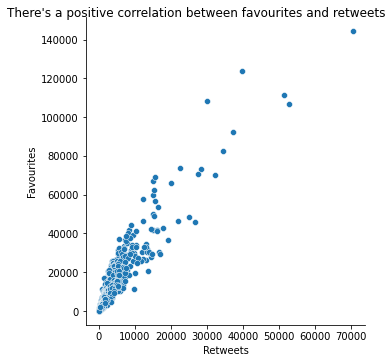

In [79]:
# Plot a scatterplot of favorite_count and retweet_count

a = sns.relplot(x='retweet_count', y='favorite_count', data=df_twitter_archive, kind='scatter')

a.fig.suptitle("There's a positive correlation between favourites and retweets", y=1)

a.set(xlabel='Retweets', ylabel='Favourites');

In [80]:
# Find the correlation using Pearson's correlation coefficient
df_twitter_archive['retweet_count'].corr(df_twitter_archive['favorite_count'])

0.9269500326651838

Visually (using the scatterplot) and using Pearson's correlation coefficient, we observe there's a very strong positive correlation (r = 0.93) between favorite_count and retweet_count. The more retweets a tweet has, the more favourites it is likely to have as well.

### Q2: Which dog stage got the most likes?

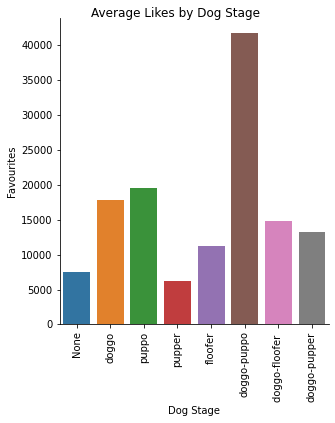

In [85]:
# Plot a bar chart of the dog stages and their average likes
b = sns.catplot(x='dog_stage', y='favorite_count', data=df_twitter_archive, kind='bar', estimator=np.mean, ci=None)

b.fig.suptitle('Average Likes by Dog Stage', y=1)

b.set(xlabel='Dog Stage', ylabel='Favourites')

plt.xticks(rotation=90);

### Q3: Which dog stage got the most retweets?

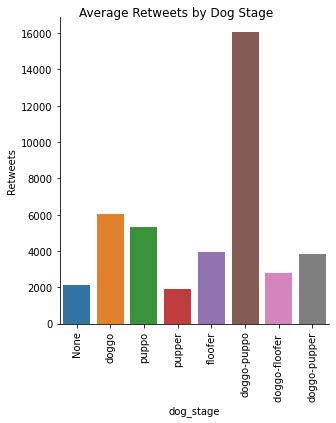

In [82]:
# Plot a bar chart of the dog stages and their average retweets
c = sns.catplot(x='dog_stage', y='retweet_count', data=df_twitter_archive, kind='bar', estimator=np.mean, ci=None)

c.fig.suptitle('Average Retweets by Dog Stage', y=1)

c.set(ylabel='Retweets')

plt.xticks(rotation=90);

Tweets of the doggo-puppo category were overwhelming the most retweeted and liked. 

### Q4: Which tweet source has the most retweets?

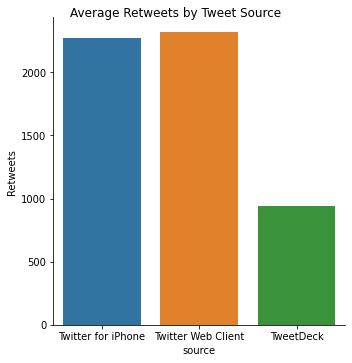

In [83]:
# Plot a bar chart of the tweet sources and their average retweets
d = sns.catplot(x='source', y='retweet_count', data=df_twitter_archive, kind='bar', estimator=np.mean, ci=None)

d.fig.suptitle('Average Retweets by Tweet Source', y=1)

d.set(ylabel='Retweets');

At face value, it seems tweeting from a web browser gathered more retweets on average.

### Q5: Which tweet source has the most likes?

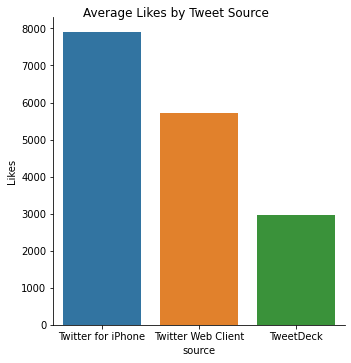

In [84]:
# Plot a bar chart of the tweet sources and their average likes
e = sns.catplot(x='source', y='favorite_count', data=df_twitter_archive, kind='bar', estimator=np.mean, ci=None)

e.fig.suptitle('Average Likes by Tweet Source', y=1)

e.set(ylabel='Likes');

At face value, it seems tweeting from an iPhone gathered more likes on average.

### Insights:
1. There's a very positive correlation (r=0.93) between retweets and favourite count of a tweet.

2. Tweets of the doggo-puppo category overwhelmingly outperformed the rest in retweets and likes.

3. Tweeting from a web browser seems to have gathered more retweets on average.

## References

Below are some of the websites I consulted for this project:

- Pandas Combine Two Columns of Text in DataFrame, SparkByExamples, [Website Link](https://sparkbyexamples.com/pandas/pandas-combine-two-columns-of-text-in-dataframe/)

- How to Convert Text Data from Requests object to DataFrame, StackOverflow, [Website Link](https://stackoverflow.com/questions/39213597/convert-text-data-from-requests-object-to-dataframe-with-pandas)

- BeautifulSoup: Extract Text from Anchor Tag, StackOverflow, [Website Link](https://stackoverflow.com/questions/11716380/beautifulsoup-extract-text-from-anchor-tag)

- Authenticate the Twitter API with Python (Tweepy), JC Chouinard, [Website Link](https://www.jcchouinard.com/how-to-use-twitter-api-with-python/)

- How to Make a Table in Jupyter Notebook, CodeGrepper, [Website Link](https://www.codegrepper.com/code-examples/typescript/how+to+make+a+table+in+jupyter+notebook)